In [88]:
import numpy as np
import matplotlib.pylab as plt
import time
from copy import deepcopy
import pickle

import importlib
import matplotlib as mpl
import matplotlib.patches as mp
import pandas as pd
import torch

from pyloric import create_prior, simulate, summary_stats
from stg_energy.common import col, svg, get_labels_8pt, check_if_close_to_obs
import stg_energy.fig1_posterior.viz as viz
import stg_energy.fig3_active_subspaces.viz as viz3
from sbi.utils import pairplot

from sbi.utils import ActiveSubspace

# Figure 1

In [5]:
pd.options.display.max_columns=999

In [6]:
%load_ext autoreload
%autoreload 2

In [8]:
PANEL_A = '../svg/panel_a.svg'
PANEL_B = '../svg/panel_b.svg'
PANEL_C = '../svg/panel_c.svg'
PANEL_D = '../svg/panel_d.svg'
PANEL_E = '../svg/panel_e.svg'
PANEL_F = '../svg/panel_f.svg'
PANEL_G = '../svg/panel_g.svg'
PANEL_H = '../svg/panel_h.svg'
PANEL_I = '../svg/panel_i.svg'

### Initialize simulator stuff

In [30]:
prior = create_prior()
sim_out = simulate(prior.sample((1,)).loc[0])
ss = summary_stats(sim_out, stats_customization={
        "plateau_durations": True,
        "num_bursts": True,
        "num_spikes": True,
        "energies": True,
        "energies_per_burst": True,
        "energies_per_spike": True,
        "pyloric_like": True,
    })
stat_names = ss.columns

### Initialize inference data

In [24]:
xo11 = np.load("../../../results/experimental_data/xo_11deg_016.npy")
xo27 = np.load("../../../results/experimental_data/xo_27deg_016.npy")

In [39]:
theta = []
x = []

for i in range(2,6):
    theta.append(np.load(f'../../../results/tmp_simulations_fig4_appendix2/posterior_samples_11_{i}.npy'))
    x.append(np.load(f'../../../results/tmp_simulations_fig4_appendix2/sim_outs_11_11_{i}.npy'))

theta_original = np.concatenate(theta)
x_original = np.concatenate(x)

In [41]:
close_enough = check_if_close_to_obs(x_original, xo=xo11[:15], check_burst_num=False)

theta_np = theta_original[close_enough]
x_np = x_original[close_enough]

theta = pd.DataFrame(theta_np, columns=prior.sample((1,)).columns)
x = pd.DataFrame(x_np, columns=stat_names)

### Select the simulations that were close

In [44]:
# path = "../../../results/simulation_data_Tube_MLslurm_cluster"
# theta = pd.read_pickle(path + '/close_to_xo_circuit_parameters.pkl')
# x = pd.read_pickle(path + '/close_to_xo_simulation_outputs.pkl')
# seeds = np.load(path + '/close_to_xo_seeds.npy')
# theta_np = theta.to_numpy()
# x_np = x.to_numpy()

In [45]:
# theta.to_numpy().shape

### Load network

In [47]:
prior = create_prior(as_torch_dist=True)
lower_bound = prior.support.lower_bound
upper_bound = prior.support.upper_bound
prior_pd = create_prior()
lims = np.asarray([lower_bound.numpy(), upper_bound.numpy()]).T

# Panel B: experimental data

In [48]:
npz = np.load('../../../results/experimental_data/supplementary_traces/data_857_016_0049.npz')
t = npz['t']
PD_spikes = npz['PD_spikes']
LP_spikes = npz['LP_spikes']
PY_spikes = npz['PY_spikes']

pdn = npz['pdn']
lpn = npz['lpn']
pyn = npz['pyn']

In [49]:
start_index = 100000
end_index   = 130000
height_offset = 200
shown_t = t[end_index] - t[start_index]
time_len = shown_t / 0.025 * 1000
dt = t[1] - t[0]

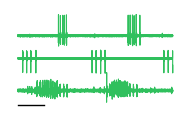

In [50]:
with mpl.rc_context(fname='../../../.matplotlibrc'):
    fig, ax = plt.subplots(1,1,figsize=(2.2, 1.3)) # (2.87, 2.08*3/4)
    ax.plot(t[start_index:end_index], 7.5+pdn[start_index:end_index]/np.max(pdn), c=col['GT'], lw=0.8)
    ax.plot(t[start_index:end_index], 6.45+lpn[start_index:end_index]/2.5/np.max(lpn), c=col['GT'], lw=0.8)
    ax.plot(t[start_index:end_index], 5+pyn[start_index:end_index]/1.2/np.max(pyn), c=col['GT'], lw=0.8)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.get_xaxis().set_ticks([])
    ax.get_yaxis().set_visible(False)
    
    duration = 0.5
    number_of_timesteps = int(duration / dt)
    t_scale = np.linspace(t[start_index], t[start_index + number_of_timesteps], 2)
    
    ax.plot(t_scale, 4.3 * np.ones_like(t_scale), c='k', lw=1.0)
    
#     plt.savefig(PANEL_exp1, facecolor='None', transparent=True)
    plt.show()

# Panel C: posterior

/home/michael/Documents/sbi/sbi/utils/plot.py:493: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if opts["labels"] == [] or opts["labels"] is None:
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


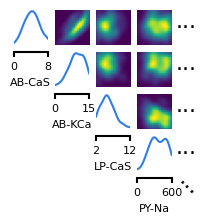

In [53]:
import matplotlib.patheffects as pe

with mpl.rc_context(fname='../../../.matplotlibrc'):

    labels_ = get_labels_8pt()
    labels_[9] += ''

    fig, axes = pairplot(samples=[theta_np[:10000]],
                           subset=[2,4,10, 16],
                           limits=lims,
                           ticks=lims,
                           fig_size=(17.0*0.12, 17.0*0.12),
                           labels=labels_,
                           scatter_offdiag={'rasterized':True, 'alpha':1.0},
                           samples_colors=[col['SNPE']],
                           diag=['kde'],
                           upper=['kde'],
                           hist_offdiag={'bins':50},
                           plot_offdiag={'linewidth': 1.6, 'path_effects':[pe.Stroke(linewidth=2.4, foreground='k'), pe.Normal()]})

#     plt.savefig(PANEL_E, facecolor='None', transparent=True)
    plt.show()

# Panel D: posterior samples

In [59]:
time_vec = np.arange(0, 11000, 0.025)

In [62]:
trace_posterior = simulate(theta.loc[0], seed=0)

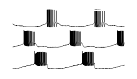

In [63]:
fig, ax = plt.subplots(1,1,figsize=(2.2,1.2))
viz.vis_sample_plain(
    voltage_trace=trace_posterior,
    t=time_vec,
    axV=ax,
    time_len=int(time_len),
    offset=45000,
    col="k",
    scale_bar=False,
    scale_bar_voltage=False,
    print_label=False,
)
# plt.savefig(PANEL_G, facecolor='None', transparent=True, dpi=300, bbox_inches='tight')
plt.show()

# Histograms

In [64]:
all_energies_per_spike = x["energies_per_spike"].to_numpy()
all_total_energies = x["energies"].to_numpy()

In [65]:
summed_energies_per_spike = np.sum(np.asarray(all_energies_per_spike), axis=1)
summed_energies_total = np.sum(np.asarray(all_total_energies), axis=1)

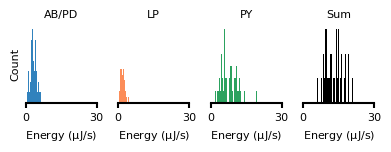

In [66]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 4, figsize=(4.5, 1))

    # / 10 because of 10 seconds simulation_time. /1000 to go from nJ to muJ
    _ = ax[0].hist(
        all_total_energies[:, 0]/10/1000, range=[0, 30], bins=100, color="#3182bd"
    )
    ax[0].set_ylabel("Count")
    ax[0].tick_params(axis="both", which="major")
    ax[0].spines["top"].set_visible(False)
    ax[0].spines["right"].set_visible(False)
    ax[0].spines["left"].set_visible(False)
    ax[0].axes.get_yaxis().set_ticks([])
    ax[0].set_title("AB/PD")

    _ = ax[1].hist(
        all_total_energies[:, 1]/10/1000, range=[0, 30], bins=100, color="#fc8d59"
    )
    # ax[1].set_ylabel('Count')
    ax[1].tick_params(axis="both", which="major")
    ax[1].spines["top"].set_visible(False)
    ax[1].spines["right"].set_visible(False)
    ax[1].spines["left"].set_visible(False)
    ax[1].axes.get_yaxis().set_ticks([])
    ax[1].set_title("LP")

    _ = ax[2].hist(
        all_total_energies[:, 2]/10/1000, range=[0, 30], bins=100, color="#2ca25f"
    )
    # ax[2].set_ylabel('Count')
    ax[2].tick_params(axis="both", which="major")
    ax[2].spines["top"].set_visible(False)
    ax[2].spines["right"].set_visible(False)
    ax[2].spines["left"].set_visible(False)
    ax[2].axes.get_yaxis().set_ticks([])
    ax[2].set_title("PY")

    _ = ax[3].hist(summed_energies_total/10/1000, range=[0, 30], bins=100, color="k")
    # ax[3].set_ylabel('Count')
    ax[3].tick_params(axis="both", which="major")
    ax[3].spines["top"].set_visible(False)
    ax[3].spines["right"].set_visible(False)
    ax[3].spines["left"].set_visible(False)
    ax[3].axes.get_yaxis().set_ticks([])
    ax[3].set_title("Sum")

    plt.subplots_adjust(wspace=0.3)

    for i in range(4):
        ax[i].set_xlim([0, 30])
        ax[i].spines["top"].set_visible(False)
        ax[i].spines["right"].set_visible(False)
        ax[i].spines["left"].set_visible(False)
        ax[i].set_xlabel("Energy ($\mu$J/s)")
        ax[i].set_xticks([0, 30])

#     plt.savefig(PANEL_H, facecolor="None", transparent=True)
    plt.show()

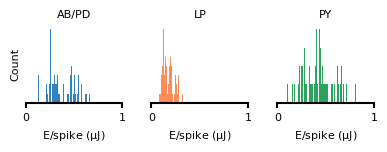

In [67]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 3, figsize=(4.5, 1))

    # The factor /4000 comes from: 10 second recording. 0.025ms stepsize -> total energy = int_energy = energy * 0.025ms = energy / 40000
    _ = ax[0].hist(all_energies_per_spike[:, 0] / 1000, range=[0, 1], bins=100, color="#3182bd")
    ax[0].set_ylabel("Count")
    ax[0].axes.get_yaxis().set_ticks([])
    ax[0].set_title("AB/PD")

    _ = ax[1].hist(
        all_energies_per_spike[:, 1] / 1000, range=[0, 1], bins=100, color="#fc8d59"
    )
    # ax[1].set_ylabel('Count')
    ax[1].set_xlabel("E/spike")
    ax[1].axes.get_yaxis().set_ticks([])
    ax[1].set_title("LP")

    _ = ax[2].hist(all_energies_per_spike[:, 2] / 1000, range=[0, 1], bins=100, color="#2ca25f")
    # ax[2].set_ylabel('Count')
    ax[2].set_xlabel("E/spike")
    ax[2].axes.get_yaxis().set_ticks([])
    ax[2].set_title("PY")

    for i in range(3):
        ax[i].set_xlim([0, 1])
        ax[i].set_xticks([0, 1])
        ax[i].set_xlabel("E/spike ($\mu$J)")
        ax[i].spines["top"].set_visible(False)
        ax[i].spines["right"].set_visible(False)
        ax[i].spines["left"].set_visible(False)

    plt.subplots_adjust(wspace=0.3)

#     plt.savefig(PANEL_I, facecolor="None", transparent=True)
    plt.show()

# Fig 3

In [75]:
with open(
    "../../../results/trained_neural_nets/inference/posterior_11deg.pickle", "rb"
) as handle:
    posterior = pickle.load(handle)

In [68]:
energies = x["energies"]

In [69]:
energies_tt = torch.as_tensor(energies.to_numpy())
x_tt = torch.as_tensor(x_np, dtype=torch.float32)

In [71]:
num_test = 0

theta_test = torch.as_tensor(theta_np[:num_test], dtype=torch.float32)
theta_train = torch.as_tensor(theta_np[num_test:], dtype=torch.float32)

In [76]:
train_energy = torch.as_tensor(
    torch.sum(energies_tt[num_test:], dim=1).unsqueeze(1), dtype=torch.float32
)
test_energy = torch.as_tensor(
    torch.sum(energies_tt[:num_test], dim=1).unsqueeze(1), dtype=torch.float32
)

# Todo

batchsize  
eval on test data

In [83]:
torch.manual_seed(0)
sensitivity = ActiveSubspace(posterior.set_default_x(xo11))
converged_nn = sensitivity.add_property(
    theta_train, train_energy, hidden_features=20, num_blocks=1
).train(training_batch_size=2)
e_vals, e_vecs = sensitivity.find_active()

In [84]:
predictions = converged_nn(theta_train).detach()

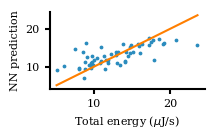

In [85]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 1.0))
    unnorm_x = train_energy[:300]
    unnorm_y = predictions[:300]
    ax.scatter(x=unnorm_x.numpy()/10/1000, y=unnorm_y.numpy()/10/1000, s=3, color="#2b8cbe")
    gt_vec = np.linspace(np.min(unnorm_x.numpy()/10/1000), np.max(unnorm_x.numpy()/10/1000), 2)
    ax.plot(gt_vec, gt_vec, "#ff7f00")
    ax.set_xlabel("Total energy ($\mu$J/s)")
    ax.set_ylabel("NN prediction")

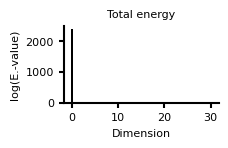

In [89]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz3.plot_eigenvalues(
        torch.abs(torch.flip(e_vals, dims=(0,))),
        figsize=(2.0, 1.0),
        ylabel="log(E.-value)",
        color="k",
        title="Total energy"
    )
    plt.show()

In [90]:
print("Ratio of first two eigenvalues:  ", e_vals[-1] / e_vals[-2])

Ratio of first two eigenvalues:   tensor(227.9532)


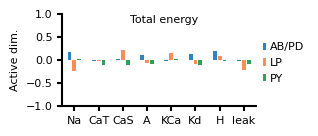

In [91]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz3.py_sensitivity_bars_cosyne(
        e_vecs[:, -1].T,
        ylim=[-1, 1.0],
        figsize=(2.5, 1.2),
        ylabel="Active dim.",
        plot_labels=True,
        title='Total energy',
    )
    plt.show()

# Fig 4

In [92]:
npz = np.load('../../../results/experimental_data/supplementary_traces/data_857_016_0069.npz')
t = npz['t']
PD_spikes = npz['PD_spikes']
LP_spikes = npz['LP_spikes']
PY_spikes = npz['PY_spikes']

pdn = npz['pdn']
lpn = npz['lpn']
pyn = npz['pyn']

In [93]:
npz = np.load('../../../results/experimental_data/supplementary_traces/data_857_016_0069.npz')
t = npz['t']
PD_spikes = npz['PD_spikes']
LP_spikes = npz['LP_spikes']
PY_spikes = npz['PY_spikes']

pdn = npz['pdn']
lpn = npz['lpn']
pyn = npz['pyn']

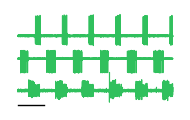

In [94]:
with mpl.rc_context(fname='../../../.matplotlibrc'):
    fig, ax = plt.subplots(1,1,figsize=(2.2, 1.3)) # (2.87, 2.08*3/4)
    ax.plot(t[start_index:end_index], 7.5+pdn[start_index:end_index]/np.max(pdn), c=col['GT'], lw=0.8)
    ax.plot(t[start_index:end_index], 6.45+lpn[start_index:end_index]/2.5/np.max(lpn), c=col['GT'], lw=0.8)
    ax.plot(t[start_index:end_index], 5+pyn[start_index:end_index]/1.2/np.max(pyn), c=col['GT'], lw=0.8)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.get_xaxis().set_ticks([])
    ax.get_yaxis().set_visible(False)
    
    duration = 0.5
    number_of_timesteps = int(duration / dt)
    t_scale = np.linspace(t[start_index], t[start_index + number_of_timesteps], 2)
    
    ax.plot(t_scale, 4.3 * np.ones_like(t_scale), c='k', lw=1.0)
    
#     plt.savefig(PANEL_exp1, facecolor='None', transparent=True)
    plt.show()

# Assemble figure

In [150]:
color_mixture1 = 0.33 * np.asarray(list(col['CONSISTENT1'])) + 0.67 * np.asarray(
    list(col['CONSISTENT2']))
color_mixture2 = 0.67 * np.asarray(list(col['CONSISTENT1'])) + 0.33 * np.asarray(
    list(col['CONSISTENT2']))

In [151]:
import time
import IPython.display as IPd

def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [152]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

startx1 = 492
startx2 = 594
starty1 = 204
starty2 = 307

endx1 = 642
endx2 = 673
endy1 = 159
endy2 = 191

deltax1 =  endx1-startx1
deltax2 =  endx2-startx2
deltay1 =  endy1-starty1
deltay2 =  endy2-starty2

sizefactor = 1.0
dshift = 0.5*factor_svg

f = Figure("20.3cm", "14.1cm",
           
    Panel(
          SVG(PANEL_A).scale(svg_scale*1.03).move(0*factor_svg, 0*factor_svg),
          Text("a", -5*factor_svg, 2.0*factor_svg-dshift, **kwargs_text),
    ).move(5*factor_svg, 0*factor_svg+dshift),

    Panel(
        SVG(PANEL_B).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("b", -2.0*factor_svg, 3.5*factor_svg-dshift, **kwargs_text),
        Text("PD", -1.*factor_svg, 7.2*factor_svg, **kwargs_text8pt),
        Text("LP", -1.*factor_svg, 11.6*factor_svg, **kwargs_text8pt),
        Text("PY", -1.*factor_svg, 15.8*factor_svg, **kwargs_text8pt),
        Text("1", 13.8*factor_svg, 3.8*factor_svg, **kwargs_text8pt),
        Text("2", 10.4*factor_svg, 9.0*factor_svg, **kwargs_text8pt),
        Text("3", 22.35*factor_svg, 9.0*factor_svg, **kwargs_text8pt),
        Text("4", 17.0*factor_svg, 12.8*factor_svg, **kwargs_text8pt),
    ).move(3.0*factor_svg, 180-1.5*factor_svg+dshift),
           
    Panel(
          SVG(PANEL_C).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
          Text("c", -3*factor_svg, 3.5*factor_svg-dshift, **kwargs_text),
    ).move(3*factor_svg, 180+19.5*factor_svg+dshift),
           
    Panel(
          SVG(PANEL_D).scale(svg_scale).move(-10*factor_svg,0*factor_svg),
          Text("d", -10.5*factor_svg, 1.5*factor_svg-dshift, **kwargs_text),
    ).move(45.5*factor_svg, 180+0.5*factor_svg+dshift),

    Panel(
          SVG(PANEL_E).scale(svg_scale).move(-10*factor_svg,0*factor_svg),
          Text("e", -10.5*factor_svg, 1.5*factor_svg-dshift, **kwargs_text),
    ).move(83.5*factor_svg, 180+0.5*factor_svg+dshift),

    Panel(
          SVG(PANEL_F).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
          Text("f", 0*factor_svg, 1.5*factor_svg-dshift, **kwargs_text),
    ).move(111*factor_svg, 180+0.5*factor_svg+dshift),

   Panel(
          SVG(PANEL_G).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
          Text("g", 0*factor_svg, 3.5*factor_svg-dshift, **kwargs_text),
    ).move(111*factor_svg, 180+19.5*factor_svg+dshift),

    Panel(
          SVG(PANEL_H).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
          Text("h", -3*factor_svg, 3.5*factor_svg-dshift, **kwargs_text),
    ).move(3*factor_svg, 180+40.5*factor_svg+dshift),

    Panel(
          SVG(PANEL_I).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
          Text("i", -3*factor_svg, 3.5*factor_svg-dshift, **kwargs_text),
    ).move(76*factor_svg, 180+40.5*factor_svg+dshift)
)

!mkdir -p fig
f.save("../fig/fig2.svg")
svg('../fig/fig2.svg')